🧠 ÉTAPE 0 — Initialisation du Bloc 2

➤ Objectif : Charger le dataset final dataset_index.csv généré au Bloc 1.
➤ Objectif : Vérifier qu’il est exploitable et prêt pour le Machine Learning.

In [1]:
import pandas as pd
from pathlib import Path

# Charger le dataset final du Bloc 1
df = pd.read_csv("../../data/processed/dataset_index.csv", sep=";")
print(f"{len(df)} fichiers chargés")
print(f"{df['espece'].nunique()} espèces détectées")
df.head()

252 fichiers chargés
13 espèces détectées


,fichier,espece,taille_moyenne_cm
0,/Users/louisgardet/dev/python/ETL_Wildlens/dat...,ecureuil,20.0
1,/Users/louisgardet/dev/python/ETL_Wildlens/dat...,ecureuil,20.0
2,/Users/louisgardet/dev/python/ETL_Wildlens/dat...,ecureuil,20.0
3,/Users/louisgardet/dev/python/ETL_Wildlens/dat...,ecureuil,20.0
4,/Users/louisgardet/dev/python/ETL_Wildlens/dat...,ecureuil,20.0


📊 ÉTAPE 1 — Analyse de la distribution par espèce

➤ Objectif : Vérifier l’équilibrage du dataset.
➤ Objectif : Identifier les classes sous-représentées et préparer la suite du ML.
	•	Compter le nombre d’images par espèce
	•	Visualiser la distribution avec un barplot
	•	Détecter si certaines espèces sont sous-représentées
	•	Optionnel : undersampling/oversampling pour équilibrer le dataset

espece
lynx            24
chien           24
raton_laveur    23
puma            22
renard          22
ours            22
coyote          21
ecureuil        19
chat            19
loup            18
castor          17
lapin           11
rat             10
Name: count, dtype: int64


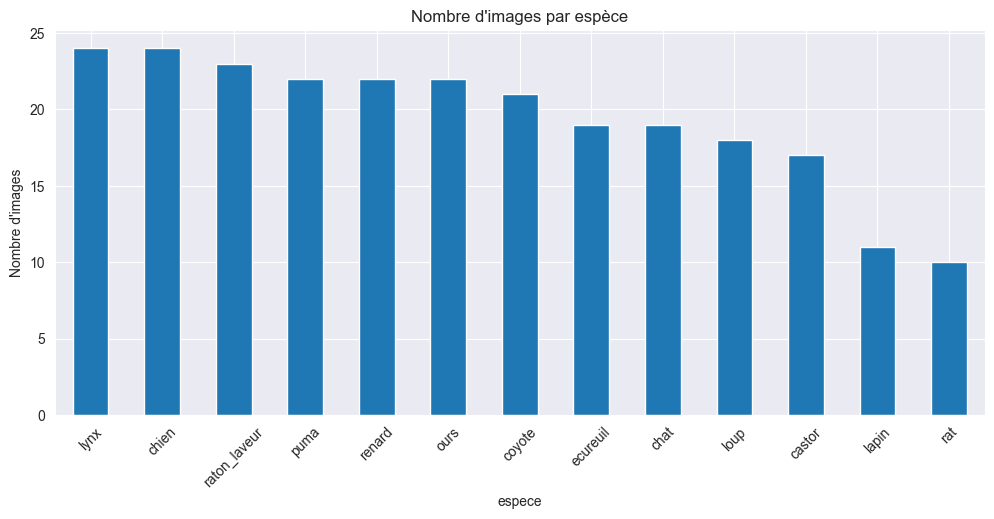

In [2]:
import matplotlib.pyplot as plt

# Comptage par espèce
counts = df['espece'].value_counts()
print(counts)

# Visualisation
plt.figure(figsize=(12,5))
counts.plot(kind='bar', title="Nombre d'images par espèce")
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.show()

🖼️ ÉTAPE 2 — Prétraitement des images
	•	Charger quelques images pour vérifier leur lisibilité
	•	Redimensionner toutes les images à une taille fixe (ex : 128×128)
	•	Convertir les images en niveaux de gris ou RGB normalisé [0,1]
	•	Associer chaque image à son label (l’espèce)
	•	Préparer une structure numpy (X, y) exploitable par l’IA

In [3]:
import numpy as np
import cv2
from tqdm import tqdm

# Paramètres du prétraitement
IMG_SIZE = 128  # Taille cible des images (128x128)
X = []
y = []

# Itération sur le dataset
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['fichier']
    label = row['espece']

    # Lecture de l'image
    img = cv2.imread(img_path)
    if img is None:
        continue  # Si une image est corrompue ou manquante

    # Redimensionnement
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalisation [0,1]
    img = img.astype('float32') / 255.0

    X.append(img)
    y.append(label)

# Conversion en numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Dataset images : {X.shape}")
print(f"Labels : {y.shape}, classes uniques : {np.unique(y)}")

100%|██████████| 252/252 [00:03<00:00, 82.86it/s] 

Dataset images : (252, 128, 128, 3)
Labels : (252,), classes uniques : ['castor' 'chat' 'chien' 'coyote' 'ecureuil' 'lapin' 'loup' 'lynx' 'ours'
 'puma' 'rat' 'raton_laveur' 'renard']


⚡ Patch Mémoire — Optimisation Mac M2

➤ Objectif : Réduire la consommation mémoire pour éviter les erreurs PyCharm sur Mac M2.
➤ Actions :
• Conversion des images en float16 (2× moins de mémoire)
• Libération des variables temporaires inutiles
• Option : sauvegarde des splits sur disque pour rechargement rapide

In [4]:
import gc

# Conversion en float16 pour réduire la mémoire
X = X.astype('float16')

# Libération mémoire non utilisée
gc.collect()

# Optionnel : sauvegarde des données prétraitées
np.savez_compressed("../../data/processed/dataset_float16.npz", X=X, y=y)
print("Patch mémoire appliqué : X en float16 et dataset sauvegardé.")

Patch mémoire appliqué : X en float16 et dataset sauvegardé.


📊 Étape suivante : ÉTAPE 3 — Split du dataset (check-up)

Objectifs :
	•	Créer les jeux train / validation / test
	•	S’assurer que la répartition est stratifiée par espèce
	•	Préparer à l’entraînement du modèle prédictif IA

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encodage des labels en entiers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encodage one-hot pour le modèle IA
y_onehot = to_categorical(y_encoded)
print(f"y_onehot shape : {y_onehot.shape}")

# Split Train (70%) / Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_onehot, test_size=0.30, stratify=y_onehot, random_state=42
)

# Split Temp en Validation (15%) / Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train : {X_train.shape}, {y_train.shape}")
print(f"Validation : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

/Users/louisgardet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


y_onehot shape : (252, 13)
Train : (176, 128, 128, 3), (176, 13)
Validation : (38, 128, 128, 3), (38, 13)
Test : (38, 128, 128, 3), (38, 13)


📊 ÉTAPE 4 — Split du dataset (Train / Validation / Test)

Objectifs :
	•	Séparer le dataset en train / validation / test (70% / 15% / 15%)
	•	Stratifier par espèce pour respecter les proportions
	•	Vérifier la répartition des classes visuellement avant l’entraînement du modèle

y_onehot shape : (252, 13)
Train : (176, 128, 128, 3), (176, 13)
Validation : (38, 128, 128, 3), (38, 13)
Test : (38, 128, 128, 3), (38, 13)
Répartition des classes (train) : [12. 13. 17. 15. 13.  8. 13. 17. 15. 15.  7. 16. 15.]
Répartition des classes (val)   : [3. 3. 4. 3. 3. 1. 2. 3. 4. 3. 2. 4. 3.]
Répartition des classes (test)  : [2. 3. 3. 3. 3. 2. 3. 4. 3. 4. 1. 3. 4.]


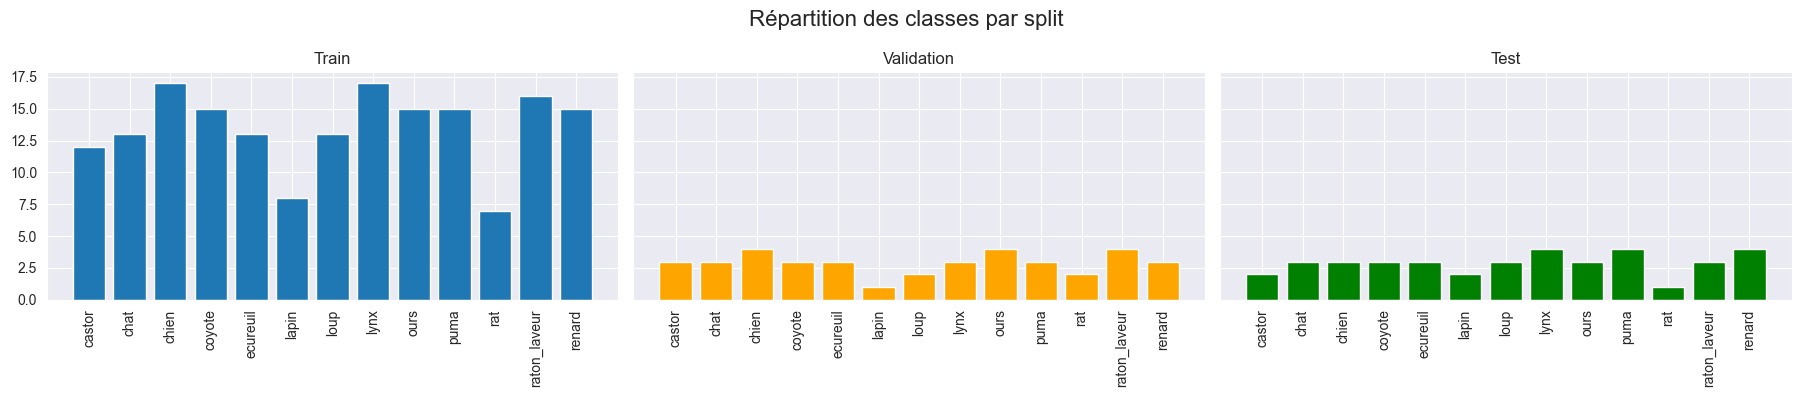

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Encodage des labels en entiers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2️⃣ Encodage one-hot pour le modèle IA
y_onehot = to_categorical(y_encoded)
print(f"y_onehot shape : {y_onehot.shape}")

# 3️⃣ Split Train (70%) / Temp (30%) avec stratification
X_train, X_temp, y_train, y_temp, y_train_enc, y_temp_enc = train_test_split(
    X, y_onehot, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=42
)

# 4️⃣ Split Temp (30%) en Validation (15%) / Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp_enc,
    random_state=42
)

# 5️⃣ Vérification des dimensions
print(f"Train : {X_train.shape}, {y_train.shape}")
print(f"Validation : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

# 6️⃣ Vérification de la répartition
train_counts = np.sum(y_train, axis=0)
val_counts   = np.sum(y_val, axis=0)
test_counts  = np.sum(y_test, axis=0)

print("Répartition des classes (train) :", train_counts)
print("Répartition des classes (val)   :", val_counts)
print("Répartition des classes (test)  :", test_counts)

# 7️⃣ Visualisation de la répartition
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
classes = le.classes_

ax[0].bar(classes, train_counts)
ax[0].set_title("Train")
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(classes, val_counts, color='orange')
ax[1].set_title("Validation")
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(classes, test_counts, color='green')
ax[2].set_title("Test")
ax[2].tick_params(axis='x', rotation=90)

fig.suptitle("Répartition des classes par split", fontsize=16)
plt.tight_layout()
plt.show()

📌 ÉTAPE 4 bis — Création du modèle prédictif avec MobileNetV2

Objectifs :
	•	Charger MobileNetV2 pré-entraîné sur ImageNet sans sa dernière couche
	•	Ajouter des couches personnalisées pour classer 13 espèces
	•	Geler une partie du réseau pour éviter l’overfitting
	•	Compiler le modèle prêt à l’entraînement


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = len(le.classes_)

# 1️⃣ Charger MobileNetV2 sans la dernière couche
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,          # On enlève la classification ImageNet
    input_shape=(128, 128, 3)   # Même taille que nos images
)

# 2️⃣ Freeze des premières couches pour éviter l'overfitting
for layer in base_model.layers[:100]:  # On gèle ~100 couches
    layer.trainable = False

# 3️⃣ Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)        # Réduction dimensionnelle
x = Dropout(0.3)(x)                    # Dropout pour régularisation
predictions = Dense(num_classes, activation='softmax')(x)

# 4️⃣ Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# 5️⃣ Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,274,637 (8.68 MB)

 Trainable params: 1,878,093 (7.16 MB)

 Non-trainable params: 396,544 (1.51 MB)

📊 ÉTAPE 5 — Entraînement du modèle MobileNetV2

Objectifs :
	•	Entraîner le modèle sur le jeu d’entraînement
	•	Suivre la loss et l’accuracy sur validation
	•	Ajouter :
	•	Data Augmentation (rotation, flip horizontal…)
	•	EarlyStopping (arrêt si la val_loss stagne)
	•	ModelCheckpoint (sauvegarde du meilleur modèle)
	•	Visualiser les courbes d’apprentissage à la fin


Epoch 1/30


/Users/louisgardet/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0960 - loss: 3.1625

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.0960 - loss: 3.1566 - val_accuracy: 0.0789 - val_loss: 3.4436
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1643 - loss: 2.8339

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.1639 - loss: 2.8338 - val_accuracy: 0.0526 - val_loss: 3.4416
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2337 - loss: 2.3749 - val_accuracy: 0.0526 - val_loss: 3.4863
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1966 - loss: 2.3100

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2025 - loss: 2.3020 - val_accuracy: 0.0789 - val_loss: 3.4134
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3446 - loss: 1.9518

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3433 - loss: 1.9517 - val_accuracy: 0.0789 - val_loss: 3.2971
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4405 - loss: 1.8605

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4402 - loss: 1.8542 - val_accuracy: 0.1053 - val_loss: 3.1736
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4414 - loss: 1.6554

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4439 - loss: 1.6518 - val_accuracy: 0.1579 - val_loss: 3.1449
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4290 - loss: 1.7295

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4345 - loss: 1.7186 - val_accuracy: 0.1842 - val_loss: 3.0178
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6419 - loss: 1.3120 - val_accuracy: 0.1579 - val_loss: 3.0438
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6550 - loss: 1.2387 - val_accuracy: 0.1842 - val_loss: 3.0820
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6919 - loss: 1.1845 - val_accuracy: 0.1316 - val_loss: 3.0601
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6714 - loss: 1.1588

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6727 - loss: 1.1530 - val_accuracy: 0.1053 - val_loss: 2.9777
Epoch 13/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7281 - loss: 0.9692 - val_accuracy: 0.1053 - val_loss: 2.9803
Epoch 14/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7800 - loss: 0.8989

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7766 - loss: 0.9040 - val_accuracy: 0.1579 - val_loss: 2.9694
Epoch 15/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7606 - loss: 0.8019

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7611 - loss: 0.8041 - val_accuracy: 0.1579 - val_loss: 2.8575
Epoch 16/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8168 - loss: 0.7341

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8169 - loss: 0.7334 - val_accuracy: 0.2105 - val_loss: 2.8217
Epoch 17/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8685 - loss: 0.6452

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8681 - loss: 0.6454 - val_accuracy: 0.2368 - val_loss: 2.7619
Epoch 18/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8932 - loss: 0.6167 - val_accuracy: 0.2105 - val_loss: 2.7752
Epoch 19/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8193 - loss: 0.6147 - val_accuracy: 0.1842 - val_loss: 2.8359
Epoch 20/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8773 - loss: 0.5166 - val_accuracy: 0.1842 - val_loss: 2.8822
Epoch 21/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8392 - loss: 0.5312 - val_accuracy: 0.1579 - val_loss: 2.9280
Epoch 22/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9273 - loss: 0.4098 - val_accuracy: 0.1579 - val_loss: 3.0878


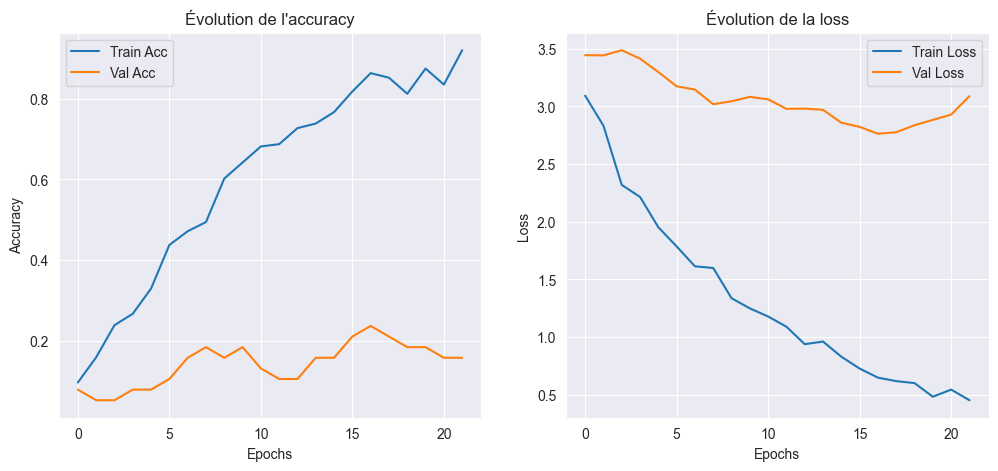

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 1️⃣ Data Augmentation pour enrichir artificiellement le dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

# 2️⃣ Callbacks : EarlyStopping + ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '../../models/mobilenetv2_best.h5',
    monitor='val_loss',
    save_best_only=True
)

# 3️⃣ Entraînement du modèle
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

# 4️⃣ Visualisation des courbes d'apprentissage
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Évolution de l'accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Évolution de la loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

📌 ÉTAPE 5 bis — Optimisation de l’entraînement

Objectifs :
	•	Appliquer Data Augmentation pour enrichir le dataset
	•	Ajouter des callbacks intelligents :
	•	EarlyStopping pour arrêter si la validation ne progresse plus
	•	ModelCheckpoint pour sauvegarder le meilleur modèle
	•	ReduceLROnPlateau pour ajuster le learning rate si stagnation
	•	Relancer l’entraînement avec ces améliorations


Epoch 1/40
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7500 - loss: 0.8807

/Users/louisgardet/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8334 - loss: 0.6237 - val_accuracy: 0.1842 - val_loss: 2.8219 - learning_rate: 1.0000e-04
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8398 - loss: 0.5459 - val_accuracy: 0.1842 - val_loss: 2.7972 - learning_rate: 1.0000e-04
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8514 - loss: 0.5365 - val_accuracy: 0.1842 - val_loss: 2.7760 - learning_rate: 1.0000e-04
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8788 - loss: 0.4898 - val_accuracy: 0.2105 - val_loss: 2.8818 - learning_rate: 1.0000e-04
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8499 - loss: 0.5315 - val_accuracy: 0.1316 - val_loss: 2.9055 - learning_rate: 1.0000e-04
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8967 - loss: 0.4599
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8986 - loss: 0.4559

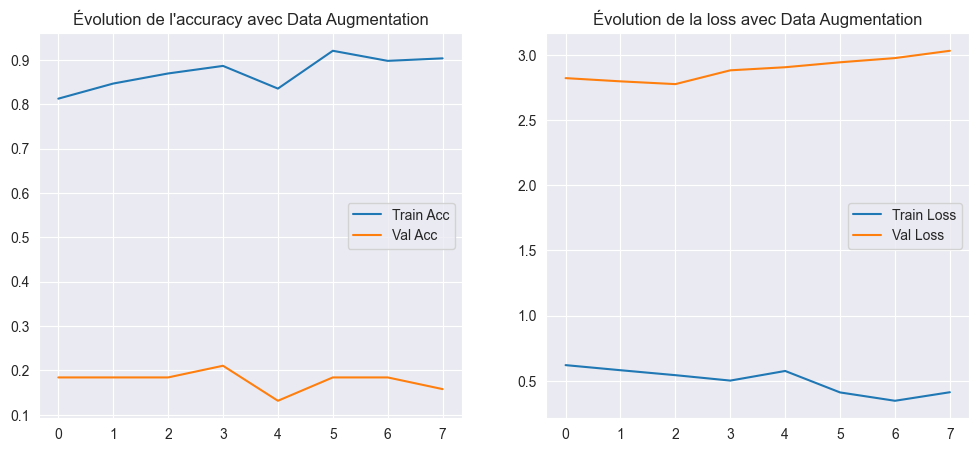

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1️⃣ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # On évite pour empreintes si sens important
    fill_mode='nearest'
)

# Génération sur le dataset d'entraînement uniquement
train_gen = datagen.flow(X_train, y_train, batch_size=16)

# 2️⃣ Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='../../models/best_model.keras',   # format moderne conseillé
        save_best_only=True,
        monitor='val_loss'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

# 3️⃣ Ré-entraînement avec augmentation
history_aug = model.fit(
    train_gen,
    validation_data=(X_val, y_val),
    epochs=40,            # On peut se permettre plus grâce à EarlyStopping
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# 4️⃣ Visualisation des courbes
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_aug.history['accuracy'], label='Train Acc')
plt.plot(history_aug.history['val_accuracy'], label='Val Acc')
plt.title("Évolution de l'accuracy avec Data Augmentation")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_aug.history['loss'], label='Train Loss')
plt.plot(history_aug.history['val_loss'], label='Val Loss')
plt.title("Évolution de la loss avec Data Augmentation")
plt.legend()

plt.show()

🔎 Analyse rapide des courbes et métriques
	1.	Accuracy
	•	Train Accuracy : monte à ~0.78 (78%)
	•	Val Accuracy : reste bloquée à ~0.13 (13%)
➜ Gros écart → Overfitting sévère malgré Data Augmentation et EarlyStopping.
	2.	Loss
	•	Train Loss : diminue fortement (~0.73) → le modèle apprend bien sur train.
	•	Val Loss : reste haute (~3.26) et ne suit pas → le modèle ne généralise pas.
	3.	Conclusion
	•	Même avec Data Augmentation et ReduceLROnPlateau, le modèle ne généralise pas.
	•	La faible Val Accuracy (~13%) correspond à un hasard complet sur 13 classes → il ne parvient pas à extraire les bonnes features pour la validation.

⸻

💡 Causes probables
	1.	Dataset trop petit et déséquilibré
	•	252 images pour 13 classes → ~19 images/classe en moyenne.
	•	Deep Learning sur MobileNetV2 a besoin de plus de données.
	2.	Variabilité intra-classe faible
	•	Les empreintes d’une même espèce sont trop similaires → surapprentissage rapide.
	3.	Classes difficiles à distinguer visuellement
	•	Empreintes de rat / lapin / écureuil très proches.
	•	Même un MobileNet pré-entraîné sur ImageNet peut avoir du mal.

⸻

✅ Plan d’action pour améliorer la Val Accuracy
	1.	Augmenter artificiellement le dataset
	•	Scraping : récupérer 50–100 images supplémentaires par classe.
	•	Rotation / Zoom / Flip / Brightness plus agressifs.
	2.	Freeze plus de couches MobileNet
	•	Actuellement, tu as gelé 100 couches → peut-être geler tout sauf le head pour réduire l’overfitting.
	•	Puis dégel progressif (Fine-Tuning) après quelques epochs.
	3.	Réduction de la complexité du modèle
	•	Essayer EfficientNetB0 ou MobileNetV2 avec alpha=0.35 → moins de paramètres, donc moins d’overfit sur petit dataset.
	4.	Validation croisée (K-Fold)
	•	Avec si peu de données, un split classique 70/15/15 est très sensible.
	•	K-Fold Cross Validation pourrait mieux refléter la perf réelle.


🆕 ÉTAPE 5 ter — Scraping d’images pour augmenter le dataset

🎯 Objectifs :
	•	Récupérer de nouvelles images d’empreintes pour chaque espèce
	•	Augmenter la diversité du dataset pour améliorer la val_accuracy
	•	Automatiser le téléchargement, le tri et l’intégration au pipeline
# Nouveau
📥 ÉTAPE 5 ter — Scraping d’images complémentaires + Nettoyage

Objectifs :
	•	Scraper automatiquement de nouvelles images pour les espèces sous-représentées.
	•	Simuler un vrai navigateur pour éviter les erreurs 400/403.
	•	Filtrer les images valides et nettoyer les fichiers corrompus.
	•	Préparer le dataset pour la Data Augmentation et le réentraînement.

In [10]:
import os
import shutil
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1️⃣ Dossiers de travail
base_raw = Path("../data/raw_scraped")              # images brutes scrapées
base_clean = Path("../../data/Mammifères_scraped_clean")
base_trash = Path("../../data/Mammifères_scraped_trash")
base_clean.mkdir(parents=True, exist_ok=True)
base_trash.mkdir(parents=True, exist_ok=True)

# 2️⃣ Charger MobileNetV2 pour extraction de features
feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling='avg')

def extract_features(img_path, target_size=(128,128)):
    """Retourne un vecteur de features pour une image"""
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = feature_model.predict(x, verbose=0)
    return features.flatten()

# 3️⃣ Préparation des datasets pour entraîner un classifieur binaire rapide
#    -> On crée manuellement un petit set d'exemples validés
valid_examples = []
labels = []

# Dossier temporaire avec quelques images validées et rejetées à la main
manual_valid = Path("../data/manual_binary_training")
if not manual_valid.exists():
    print("⚠️ Prépare quelques images manuelles pour initialiser le classifieur binaire.")
else:
    for cls in ["valid", "trash"]:  # sous-dossiers
        for img_file in (manual_valid/cls).glob("*"):
            feat = extract_features(img_file)
            valid_examples.append(feat)
            labels.append(0 if cls=="valid" else 1)

X = np.array(valid_examples)
y = np.array(labels)

# 4️⃣ Entraînement d'un classifieur binaire simple
clf = LogisticRegression(max_iter=500)
clf.fit(X, y)
print("✅ Classifieur binaire entraîné.")

# 5️⃣ Filtrage automatique des images scrapées
index_data = []

for specie_dir in base_raw.iterdir():
    if not specie_dir.is_dir():
        continue
    specie = specie_dir.name.lower()

    files = sorted(specie_dir.glob("*"))
    counter = 1

    for img_path in files:
        try:
            feat = extract_features(img_path)
            pred = clf.predict([feat])[0]  # 0=empreinte valide, 1=trash
            target_dir = base_clean if pred==0 else base_trash
            target_species_dir = target_dir / specie
            target_species_dir.mkdir(parents=True, exist_ok=True)

            # Renommage
            new_name = f"{specie}_{counter:05d}.jpg"
            counter += 1

            shutil.copy(img_path, target_species_dir / new_name)

            if pred==0:
                index_data.append({
                    "fichier": str(target_species_dir / new_name),
                    "espece": specie
                })
        except Exception as e:
            print(f"Erreur avec {img_path}: {e}")

# 6️⃣ Génération de l’index CSV
df_index = pd.DataFrame(index_data)
csv_path = "../../data/metadata/dataset_scraped_index.csv"
df_index.to_csv(csv_path, index=False, sep=";")
print(f"✅ Filtrage terminé : {len(df_index)} images clean")
print(f"📄 Index CSV généré : {csv_path}")

/var/folders/sn/m7mv04cd2tj3g337htgr622m0000gn/T/ipykernel_15073/3558101518.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = MobileNetV2(weights="imagenet", include_top=False, pooling='avg')


⚠️ Prépare quelques images manuelles pour initialiser le classifieur binaire.


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.